<a href="https://colab.research.google.com/github/erksch/chemical-disease-ner/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chemical Disease NER


This notebook provides a Named Entity Recognizer for the BioCreative V challenge dataset. We will describe our implementation of data loading, processing, the use of embeddings, our model architecture and the training process briefly, with more details provided in our paper.

For our model we use a bidirectional LSTM, evaluations on additional char input, the use of pretrained embeddings an more is explained in the paper.
The implementation in this notebook resembels the baseline implementation mentioned in the paper.

Our full implementation as well as our paper can be found on [Github](https://https://github.com/erksch/chemical-disease-ner) 


## Data Loading and Processing

The dataset is provided in XML format. The following code provides a data parser extracting the tokens from the XML format and converting it in a format fit for training.

Download Data

In [ ]:
!wget https://chemicalnerdata.s3.amazonaws.com/CDR_TrainingSet.BioC.xml
!wget https://chemicalnerdata.s3.amazonaws.com/CDR_DevelopmentSet.BioC.xml
!wget https://chemicalnerdata.s3.amazonaws.com/CDR_TestSet.BioC.xml

--2020-07-31 21:36:27--  https://chemicalnerdata.s3.amazonaws.com/CDR_TrainingSet.BioC.xml
Resolving chemicalnerdata.s3.amazonaws.com (chemicalnerdata.s3.amazonaws.com)... 52.217.86.236
Connecting to chemicalnerdata.s3.amazonaws.com (chemicalnerdata.s3.amazonaws.com)|52.217.86.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2519542 (2.4M) [text/xml]
Saving to: ‘CDR_TrainingSet.BioC.xml’

CDR_TrainingSet.Bio 100%[===================>]   2.40M  5.27MB/s    in 0.5s    

2020-07-31 21:36:28 (5.27 MB/s) - ‘CDR_TrainingSet.BioC.xml’ saved [2519542/2519542]

--2020-07-31 21:36:29--  https://chemicalnerdata.s3.amazonaws.com/CDR_DevelopmentSet.BioC.xml
Resolving chemicalnerdata.s3.amazonaws.com (chemicalnerdata.s3.amazonaws.com)... 52.216.18.240
Connecting to chemicalnerdata.s3.amazonaws.com (chemicalnerdata.s3.amazonaws.com)|52.216.18.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2538784 (2.4M) [text/xml]
Saving to: ‘CDR_Development

In [ ]:
import time
import torch
import numpy as np
import gensim
from xml.dom import minidom
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def process_dataset_xml(file_path):
    xml = minidom.parse(file_path)
    documents = xml.getElementsByTagName('document')
    all_sentences = []
    
    for document in documents:
        text = ""
        passages = document.getElementsByTagName('passage')
        assert(len(passages) == 2)
        title, abstract = passages
        text += get_text(title.getElementsByTagName('text')[0])
        text += ' '
        text += get_text(abstract.getElementsByTagName('text')[0])
        annotations = document.getElementsByTagName('annotation')
        sentences = sent_tokenize(text)
        tokens = [word_tokenize(sentence) for sentence in sentences]
        
        labels = []
        
        for annotation in annotations:
            entity = get_text(annotation.getElementsByTagName('infon')[0])
            location = annotation.getElementsByTagName('location')[0]
            offset = int(location.attributes['offset'].value)
            length = int(location.attributes['length'].value)
            labels.append([text[offset:offset+length], entity])


        flat_labels = []

        for label_text, label in labels:
            label_tokens = word_tokenize(label_text)
            for token in label_tokens:
                flat_labels.append([token, label])

        labels = flat_labels

        token_labels = []
        label_idx = 0
        label_start = 0
        
        for sentence in tokens:
            out = []
            
            for token in sentence:
                if label_idx == len(labels):
                    out.append([token, 'O'])
                    continue
                    
                text, entity = labels[label_idx]
                text = text[label_start:]
                
                if token == text:
                    label_idx += 1
                    out.append([token, entity])
                    label_start = 0
                elif text.startswith(token):
                    label_start += len(token)
                    out.append([token, entity])
                elif text in token:
                    label_idx += 1
                    out.append([token, entity])
                else:
                    out.append([token, 'O'])
                    label_start = 0
            
            token_labels.append(out)

        for sentence in token_labels:
            all_sentences.append(sentence)

    return all_sentences

def get_text(node):
    return node.childNodes[0].data

def text_to_indices(sentences, word2Idx, label2Idx):
    unknown_idx = word2Idx['UNKNOWN_TOKEN']
    padding_idx = word2Idx['PADDING_TOKEN']

    X = []
    Y = []

    null_label = 'O'

    for sentence in sentences:
        word_indices = []
        label_indices = []

        for word, label in sentence:
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]
            else:
                wordIdx = unknown_idx
            word_indices.append(wordIdx)
            label_indices.append(label2Idx[label])

        X.append(word_indices)
        Y.append(label_indices)

    return X, Y


In [ ]:
training_set_path = "CDR_TrainingSet.BioC.xml"
test_set_path = "CDR_TestSet.BioC.xml"
train_sentences = process_dataset_xml(training_set_path)
test_sentences = process_dataset_xml(test_set_path)

In [ ]:
import torch
from torch.utils.data import Dataset, Sampler

class CDRDataset(Dataset):

    def __init__(self, X, Y, word2Idx, label2Idx, pad_sentences=True, pad_sentences_max_length=-1):
        self.X = X
        self.Y = Y
        self.word2Idx = word2Idx
        self.label2Idx = label2Idx
        self.max_length = pad_sentences_max_length
        
        if pad_sentences:
            self._pad_sentences()
        
    def _pad_sentences(self):
        pad_token = self.word2Idx['PADDING_TOKEN']
        pad_label = self.label2Idx['O']

        if self.max_length == -1:
            for sentence in self.X:
                self.max_length = max(self.max_length, len(sentence))

        print(f"Padding sentences to length {self.max_length} with padding token {pad_token}.")

        for i, sentence in enumerate(self.X):
            if len(sentence) > self.max_length:
                self.X[i] = self.X[i][:self.max_length]
                self.Y[i] = self.Y[i][:self.max_length]

            while len(sentence) < self.max_length:
                self.X[i].append(pad_token)
                self.Y[i].append(pad_label)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.LongTensor(self.X[idx]).to('cuda'), torch.LongTensor(self.Y[idx]).to('cuda')

class UniqueSentenceLengthSampler(Sampler):
    
    def __init__(self, data_source):
        self.data_source = data_source
        self.sentence_lengths = set()

        for x, _ in data_source:
            self.sentence_lengths.add(len(x))

    def __iter__(self):
        batch = []
        for sentence_length in self.sentence_lengths:
            for idx in range(len(self.data_source)):
                x, _ = self.data_source[idx]
                if (len(x) == sentence_length):
                    batch.append(idx)
            yield batch
            batch = []

    def __len__(self):
        return len(self.data_source)

## Embeddings

For this example we use our own embeddings. We also experimented with pretrained embeddings, more on that in our paper.

In [ ]:
def extract_words_and_labels(sentences):
    labels = set()
    words = set()

    print("Extracting words and labels...")
    for sentence in sentences:
        for token, label in sentence:
            labels.add(label)
            words.add(token.lower())
    print(f"Extracted {len(words)} words and {len(labels)} labels.")

    return words, labels
    
def prepare_indices(sentences):
    words, labels = extract_words_and_labels(sentences)

    # mapping for words
    word2Idx = {}
    word2Idx["PADDING_TOKEN"] = 0
    word2Idx["UNKNOWN_TOKEN"] = 1

    for word in words:
        word2Idx[word] = len(word2Idx)

    # mapping for labels
    label2Idx = {}
    for label in labels:
        label2Idx[label] = len(label2Idx)
    
    idx2Label = {v: k for k, v in label2Idx.items()}

    return word2Idx, label2Idx, idx2Label


In [ ]:
word2Idx, label2Idx, idx2Label = prepare_indices(train_sentences)

Extracting words and labels...
Extracted 10400 words and 3 labels.


## Model

Our model is a bidirectional LSTM with an embedding layer for the inputs and a linear layer reducing the output to our 3 classes. 

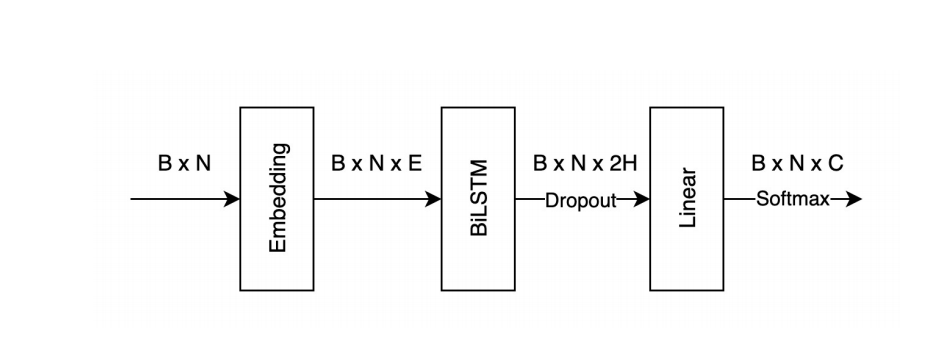

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
        super(BiLSTM, self).__init__()
  
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, bidirectional=True)
        self.linear = nn.Linear(self.hidden_dim* 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.linear(x)

        return x


In [ ]:
embedding_dim=200 
hidden_dim=200
model_args = {}
vocab_size = len(word2Idx)
num_classes = len(label2Idx)
device = torch.device('cuda')
f1_scores = {label: 0.0 for label in idx2Label.keys()}

model = BiLSTM(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab_size=vocab_size, num_classes=num_classes, **model_args).to(device)

X_train, Y_train = text_to_indices(train_sentences, word2Idx, label2Idx)


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [ ]:
print("Train dataset class distribution:")
total = len([token for sentence in Y_train for token in sentence])
non_null_class_weight = 1.0
null_class_weight = 0.1
weights = []
print(f"Total of {total} tokens")
for i, label in enumerate(label2Idx):
    count = 0
    for sentence in Y_train:
        count += len(np.where(np.array(sentence) == label2Idx[label])[0])
    end = ' | ' if i < len(label2Idx) -1 else ''
    print(f"{label} {count} {count / total:.2f}", end=end)

    weight = non_null_class_weight if (count / total) < 0.1 else null_class_weight
    weights.append(weight)
print()
print(f"Weights: {weights}")

X_test, Y_test = text_to_indices(test_sentences, word2Idx, label2Idx)

Train dataset class distribution:
Total of 107488 tokens
Disease 6387 0.06 | Chemical 5579 0.05 | O 95522 0.89
Weights: [1.0, 1.0, 0.1]


In [ ]:
dataset_args = {}
dataset = CDRDataset(X_train, Y_train, word2Idx, label2Idx, **dataset_args)

Padding sentences to length 111 with padding token 0.


##  Batching


We train using a batch size of one for simplicity reasons. As our input data per batch needs to be rectangular we can either pad sentences of different lengths to achieve this or use only one sentence per batch. These approaches are evaluated in our paper.

In [ ]:
# single, padded_sentences, by_sentence_length
batch_mode="single"
padded_sentences_batch_size=100
# set to -1 to use max sentence length of train set
padded_sentences_max_length=20

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Training

This shows an example training run using a SDG as optimizer.


In [ ]:
learning_rate=0.001
sgd_momentum=0.9
epochs=50

loss_args = { "weight": torch.FloatTensor(weights).to(device) }
criterion = nn.CrossEntropyLoss(**loss_args)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def predict_dataset(X, Y, net):
    all_true_labels = []
    all_predicted_labels = []

    for i, x in enumerate(X):
        tokens = torch.LongTensor([x]).to(device)
        true_labels = torch.LongTensor(Y[i]).to(device)

        predicted_labels = net(tokens)
        predicted_labels = predicted_labels.argmax(axis=2).squeeze(dim=0)

        for j in range(len(true_labels)):
            all_true_labels.append(true_labels[j].item())
            all_predicted_labels.append(predicted_labels[j].item())

    return torch.LongTensor(all_true_labels), torch.LongTensor(all_predicted_labels)

In [ ]:
print("Training...")
n_iter = 0
for epoch in range(epochs):
    epoch_start = time.time()
    model.train()

    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()

        prediction = model(batch_x).reshape(-1, num_classes)
        loss = criterion(prediction, batch_y.reshape(-1))

        loss.backward()
        optimizer.step()

        n_iter += 1

    epoch_end = time.time()

    print(f"Epoch {epoch + 1} | Loss {loss.item():.2f} | Duration {(epoch_end - epoch_start):.2f}s")

    should_evaluate = (epoch + 1) == epochs or epoch % 5 == 0 # only evaluate every 5th epoch for performance

    if should_evaluate:
        model.eval()

        with torch.no_grad():
            eval_total_start = time.time()

            for set_name,X, Y in [('train',X_train, Y_train), ('test', X_test, Y_test)]:
                eval_set_start = time.time()
                ground_truth, predictions = predict_dataset(X, Y, model)
                true_positives = (ground_truth == predictions).sum().item()
                accuracy = true_positives / len(ground_truth)
                
                print(f"{set_name} set evaluation:")
                
                for label in idx2Label.keys():
                    indices_in_class = torch.where(ground_truth == label)[0]
                    true_positives = (ground_truth[indices_in_class] == predictions[indices_in_class]).sum().item()
                    false_negatives = len(indices_in_class) - true_positives
            
                    recall = true_positives / len(indices_in_class)

                    indices_predicted_in_class = torch.where(predictions == label)[0]
                    false_positives = (ground_truth[indices_predicted_in_class] != predictions[indices_predicted_in_class]).sum().item()

                    if true_positives + false_positives == 0:
                        precision = 0
                    else:
                        precision = true_positives / (true_positives + false_positives)

                    f1_score = (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)
                    f1_scores[label] = f1_score

                    print(f"\t{idx2Label[label]:<8} | P {precision:.2f} | R {recall:.2f} | F1 {f1_score:.2f}")

                eval_set_end = time.time()
                print(f"\tTook {(eval_set_end - eval_set_start):.2f}s")

            eval_total_end = time.time()
            print(f"\Total evaluation duration {(eval_total_end - eval_total_start):.2f}s")

f1_mean = (f1_scores[label2Idx['Disease']] + f1_scores[label2Idx['Chemical']]) / 2
print(f"Mean f1 score: {f1_mean}")

Training...
Epoch 1 | Loss 0.03 | Duration 9.50s
train set evaluation:
	Disease  | P 0.64 | R 0.91 | F1 0.75
	Chemical | P 0.85 | R 0.95 | F1 0.90
	O        | P 1.00 | R 0.99 | F1 1.00
	Took 18.33s
test set evaluation:
	Disease  | P 0.55 | R 0.75 | F1 0.63
	Chemical | P 0.37 | R 0.93 | F1 0.53
	O        | P 0.99 | R 0.89 | F1 0.93
	Took 5.88s
\Total evaluation duration 24.20s
Epoch 2 | Loss 0.03 | Duration 9.39s
Epoch 3 | Loss 0.02 | Duration 9.39s
Epoch 4 | Loss 0.02 | Duration 9.36s
Epoch 5 | Loss 0.05 | Duration 9.33s
Epoch 6 | Loss 0.00 | Duration 9.41s
train set evaluation:
	Disease  | P 0.64 | R 0.91 | F1 0.75
	Chemical | P 0.85 | R 0.95 | F1 0.90
	O        | P 1.00 | R 0.99 | F1 1.00
	Took 18.18s
test set evaluation:
	Disease  | P 0.55 | R 0.75 | F1 0.63
	Chemical | P 0.37 | R 0.93 | F1 0.53
	O        | P 0.99 | R 0.89 | F1 0.93
	Took 5.87s
\Total evaluation duration 24.05s
Epoch 7 | Loss 0.01 | Duration 9.31s
Epoch 8 | Loss 0.14 | Duration 9.35s
Epoch 9 | Loss 0.06 | Duration 9

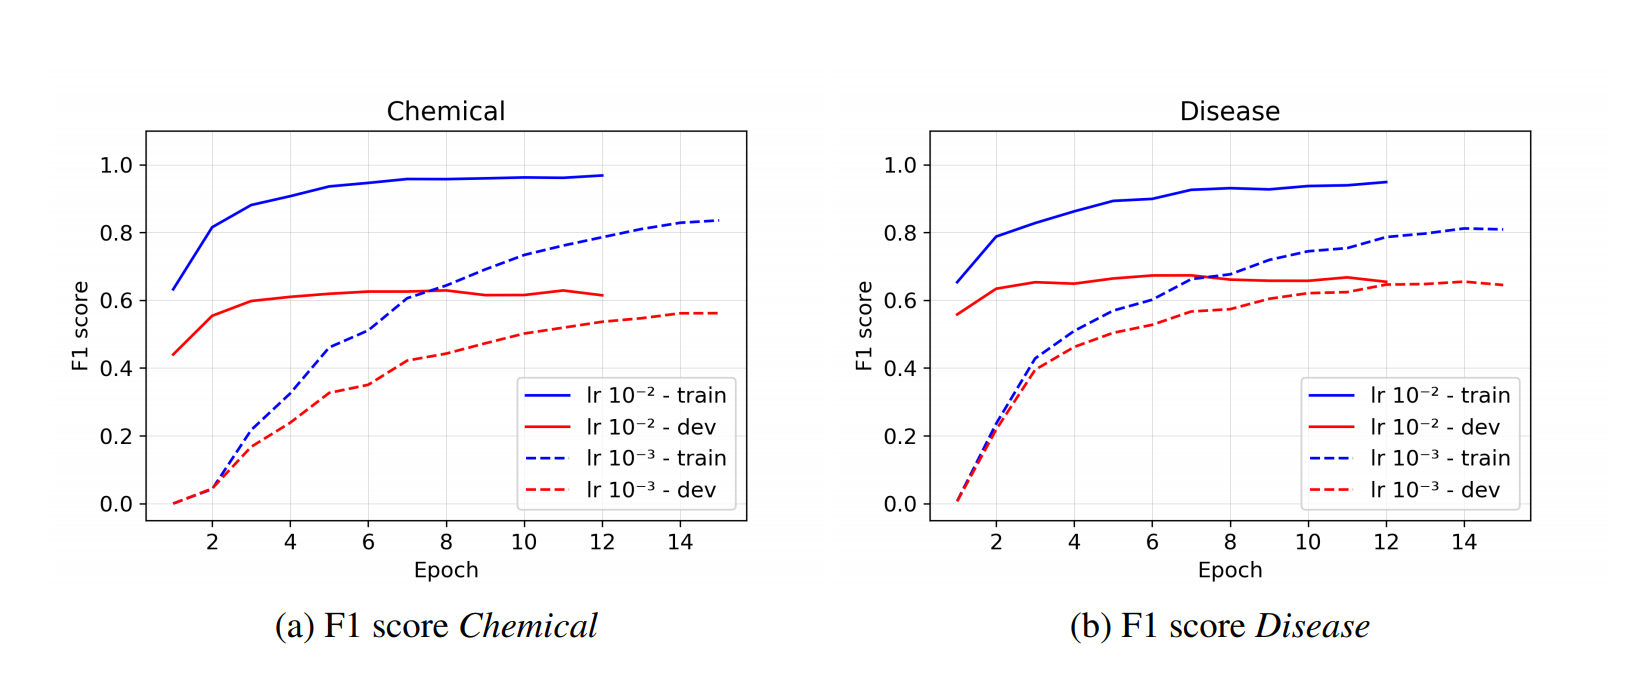

Our primary metric are F1 scores. Due to the spares data (only 11% of tokens are tagged as non no-entity) focussing on precision or recall would lead to the model labeling entitys as non entity. The above figure shows a training run where we compare different learning rates. It can be seen that out test F1 scores cap at around 0.6 for both entities, with disease's score slightly higher. The model with the best performance used pre-trained embeddings,and char input, and yielded F1 scores of 0.85 and 0.79 for chemicals and diseases. All details can be found in our papers evaluation section.